Verification of legal age for alcohol purchase from customers photo

The goal of this project is to assist supermarket chain Good Seed to sell alcohol to people who are not underage so that laws can be followed without any error.
Computer vision methods will be  used to determine age of a person from a photo.Then build and evaluate a model for verifying people's age.


In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pip install mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
path = '/content/drive/My Drive/computer_vision'

In [5]:
labels = pd.read_csv(path + '/labels.csv')
labels

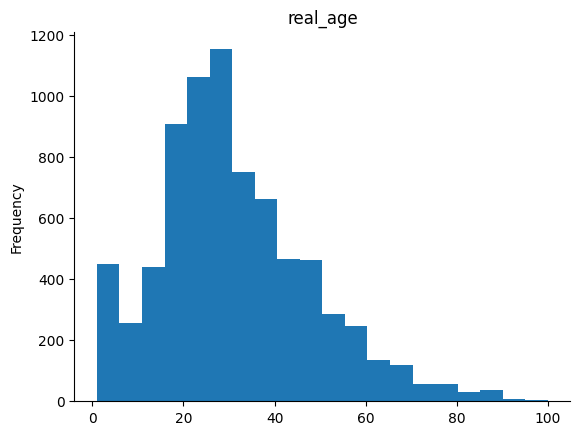

In [6]:
from matplotlib import pyplot as plt
labels['real_age'].plot(kind='hist', bins=20, title='real_age')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### In the above histogram we can see that the most ages in the dataset fall between 20 - 40 years. also we can see that as age increases the number of people decreases based on our dataset.

## Analyzing couple images with different channels and comparing them with original images

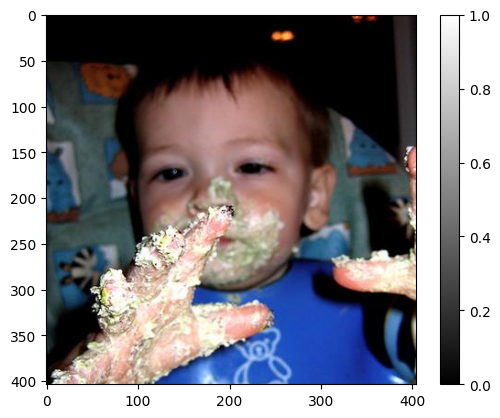

In [7]:
image40= Image.open(path + "/final_files/000040.jpg")
array = np.array(image40)
array= array/255

plt.imshow(array, cmap='gray')
plt.colorbar()


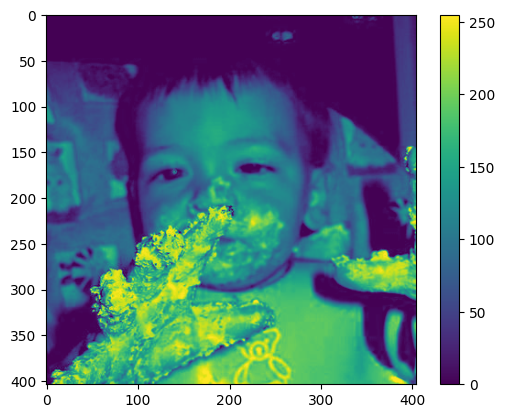

In [8]:

array = np.array(image40)
blue_channel= array[:, :, 2]
plt.imshow(blue_channel)
plt.colorbar()

#### In above 2 images first one is original images where we can see all the color channels properly red, blue and green. But second image we can see that tshirt color value is around 255 which is high values as we are looking into blue channels.

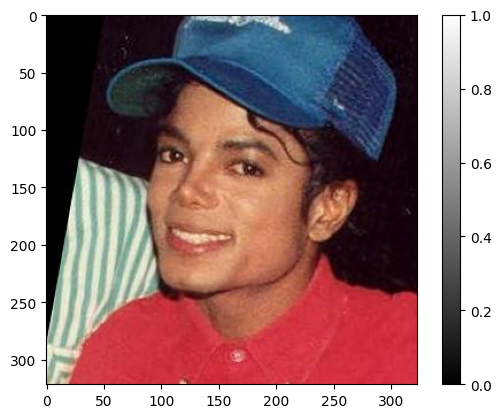

In [9]:
image94 = Image.open(path + "/final_files/000094.jpg")
array = np.array(image94)
array = array/255

plt.imshow(array, cmap='gray')
plt.colorbar()

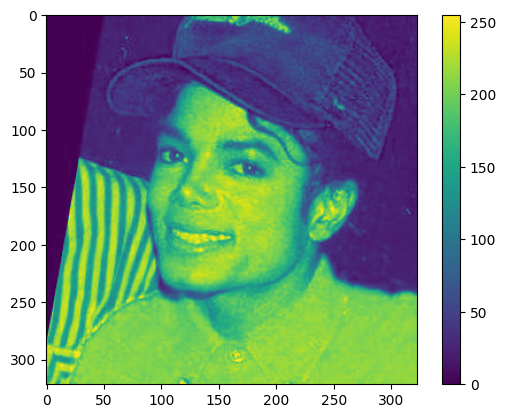

In [10]:

array = np.array(image94)

red_channel = array[:, :, 0]
plt.imshow(red_channel)
plt.colorbar()


#### In above Michael Jackson image we can notice that as we are looking into red channel the red tshirt value is around 250 but the blue cap is almost 0 because we are just looking into red channel so red tshirt has highest value.Blue cap would have highest value if we were displaying blue channel.

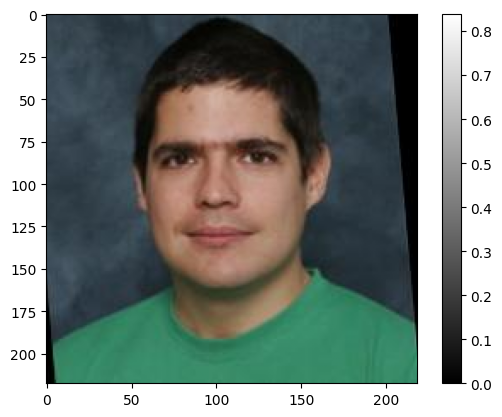

In [11]:
image453 = Image.open(path + "/final_files/000453.jpg")
array = np.array(image453)
array = array/255

plt.imshow(array, cmap='gray')
plt.colorbar()

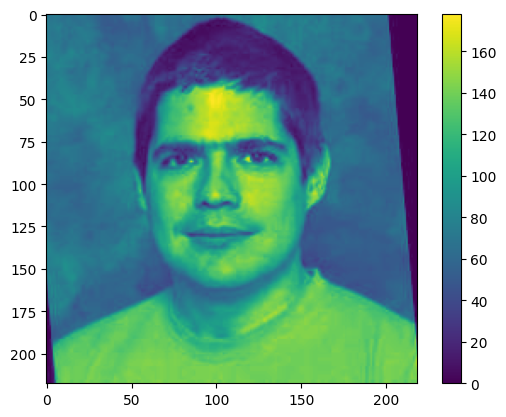

In [12]:
array = np.array(image453)
green_channel = array[:, :, 1]
plt.imshow(green_channel)
plt.colorbar()


#### In above image we can notice that as we are looking into green channel the green tshirt value is more than 160 which is higher than other colours as we are looking at green channel.

In [13]:
label_path= path+ '/labels.csv'
images_path = path+ '/final_files/'
print('Labels_path:', path+ '/labels.csv')
print('Images_path:', path+ '/final_files/')

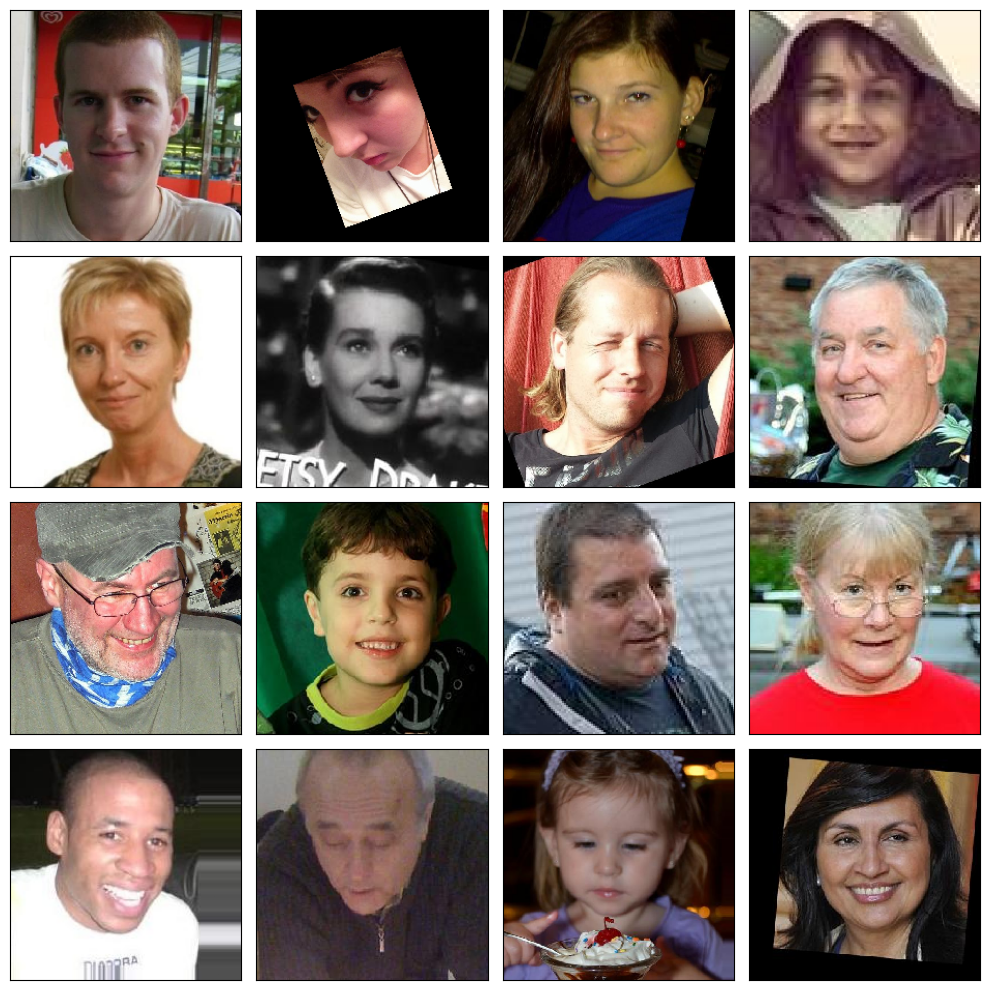

In [14]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(validation_split= 0.25, rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/drive/My Drive/computer_vision/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)

features, target = next(train_gen_flow)
print()

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Printed couple image from training dataset.

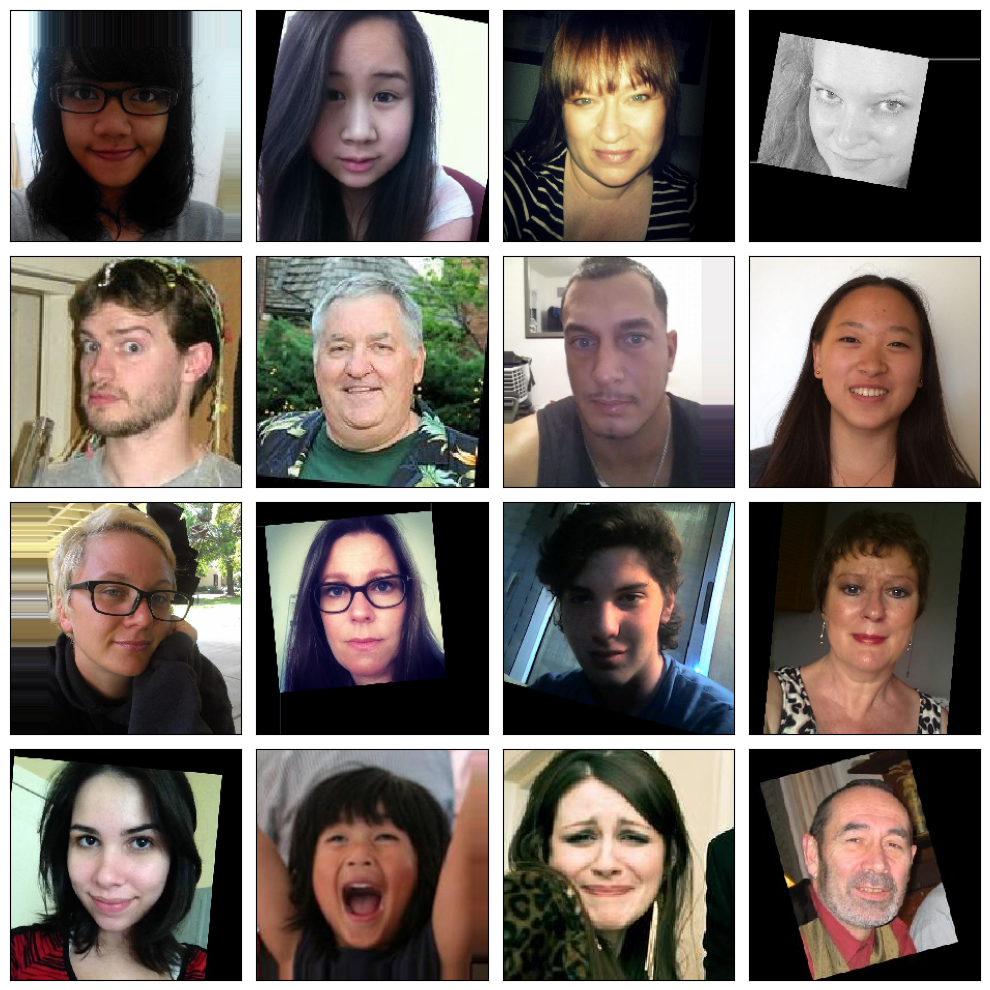

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1./255)
test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + '/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)


features, target = next(test_gen_flow)
print()

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Printed couple image from testing dataset.

In [16]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


In [17]:
def load_train(path):

    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split= 0.25, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe= labels,
        directory = path + 'final_files/',
        x_col= 'file_name',
        y_col= 'real_age',
        target_size=(224, 224),
        batch_size= 32,
        class_mode='raw',
        subset='training',
        seed= 12345)

    return train_gen_flow

In [18]:
def load_test(path):

    """
    It loads the test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe= labels,
        directory = path + 'final_files/',
        x_col= 'file_name',
        y_col= 'real_age',
        target_size=(224, 224),
        batch_size= 32,
        class_mode='raw',
        subset='validation',
        seed= 12345)

    return test_gen_flow


In [19]:
def create_model(input_shape):

    """
    It defines the model
    """
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [20]:
input_shape = (224, 224, 3)
model = create_model(input_shape)

model.summary()

In [21]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

if 'name' == "main":
    train_data_path = "/content/drive/My Drive/train"
    test_data_path = "/content/drive/My Drive/valid"

    train_data = load_train(train_data_path)
    test_data = load_test(test_data_path)

    input_shape = (224, 224, 3)
    model = create_model(input_shape)

    model = train_model(model, train_data, test_data, epochs=20)

    model.save("age_prediction_model.h5")



Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

### As we can see in above output that the loss is reducing after every epoch is run. On the Epoch 1 the loss was 95.35 and on the epoch 20 the loss went down to 17.01 so it means that running 20 epochs helped the model to produce better model prediction for ages of the people. The model's mae score is under 8.

In [22]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam



init_str = label_path

import inspect

with open('run_model_on_gpu.py', 'w') as f:

    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [23]:
!python "/content/drive/My Drive/computer_vision/run_model_on_gpu.py"

### Changed the runtime to gpu time.

In [24]:
!ls "/content/drive/My Drive/computer_vision"


## Conclusion

### The goal of this project is to assist supermarket chain Good Seed to sell alcohol to people who are not underage so that laws can be followed without any error. Computer vision methods will be used to determine age of a person from a photo.Then build and evaluate a model for verifying people's age.

### Some analysis of multiple images were done. In the original images all the colors like red, blue and green were properly visible. But when we look into different channel like red, green or blue, the value of the respective channel is highest and other colors is lowest.

### As we can see in above output that the loss is reducing after every epoch is run. On the Epoch 1 the loss was 95.35 and on the epoch 20 the loss went down to 17.01 so it means that running 20 epochs helped the model to produce better model prediction for ages of the people.

### The mae of the model is under 8 which is good model prediction as lesser the mean absolute error better the model gets.